In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
from itertools import cycle
from wordcloud import WordCloud, ImageColorGenerator
import seaborn as sns
from tqdm import tqdm
from gensim.models import LsiModel
import gensim
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Loading the data

In [ ]:
data=pd.read_csv('final_file.csv')
test=pd.read_csv('labelled_data.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning

In [ ]:
data=data.loc[:, ['title', 'summary','body','miscellaneous','date']] 
data=data[data.body.isnull()==False]
df=data['body']
df=pd.DataFrame(df)
df.head()

,body
0,Jodhpur: A flying officer of the Indian Air Fo...
1,The Allahabad High Court has ordered the Uttar...
2,"Bengaluru: Three Infosys employees, attached t..."
3,New Delhi: The government has directed the Cen...
4,Manchester United won 2-0 vs Manchester City l...


In [ ]:
test=test[['Body','Category']]
test=test[test['Body'].isnull()==False]
test=test.drop(4796)
test=test.drop(5239)
test=test.set_index(pd.Series([i for i in range(0,len(test))]))
test['Body']=test['Body'].astype(str)
test['Category']=test['Category'].astype(str)
test.head()

,Body,Category
0,"Following the outbreak of coronavirus, the sho...",entertainment
1,June 10 marked the first death anniversary of ...,entertainment
2,The trailer of Relic starring Emily Mortimer i...,entertainment
3,Even though the lockdown is being lifted in ph...,entertainment
4,"Saiyami Kher, who was recently seen in Netflix...",entertainment


## Data Preprocessing

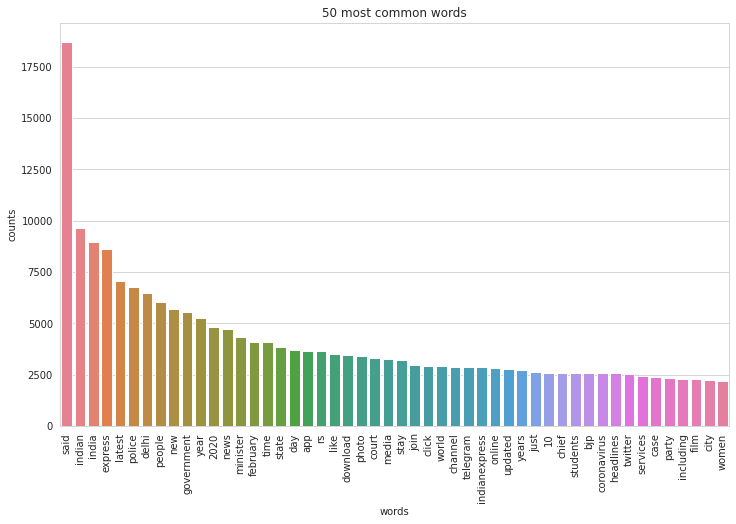

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_50_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:50]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(12, 12/1.6180))
    plt.subplot(title='50 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(data['body'])
# Visualise the 20 most common words
plot_50_most_common_words(count_data, count_vectorizer)

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
lemma = WordNetLemmatizer()
stopword_set = set(stopwords.words('english'))

def process(string):
    string=' '.join([word if word not in stopword_set else '' for word in string.split()])
    string=string.lower()
    string=re.sub(' for ',' ', string)
    string=re.sub(' said ',' ', string)
    string=re.sub(' indian ',' ', string)
    string=re.sub(' express ',' ', string)
    string=re.sub(' download ',' ', string)
    string=re.sub(' telegram ',' ', string)
    string=re.sub(' app ',' ', string)

    string=re.sub(' click ',' ', string)
    string=re.sub(' rs ',' ', string)
    string=re.sub(' indianexpress ',' ', string)
    string=re.sub(' news ',' ', string)
    string=re.sub(' s ',' ', string)
    string=re.sub(' the ',' ', string)
    string=re.sub(' a ',' ', string)
    string=re.sub(' with ',' ', string)
    string=re.sub(' is ',' ', string)
    string=re.sub(' at ',' ', string)
    string=re.sub(' to ',' ', string)
    string=re.sub(' by ',' ', string)
    string=re.sub(' & ',' ', string)
    string=re.sub(' of ',' ', string)
    string=re.sub(' are ',' ', string)
    
    return string

In [ ]:
def te(i):
  print(data['body'][i])
  print(process(data['body'][i]))

In [ ]:
import re
def preprocess(text):
    #str=process(str)
    # remove links
    text = re.sub(r'http(s)?:\/\/\S*? ', "", text)
    return(text)


In [ ]:
def preprocess_document(text):
  text=process(text)
  text = preprocess(text)
  return(''.join([x if x.isalnum() or x.isspace() else " " for x in text ]).split())

In [ ]:
df['body']=df['body'].astype(str)

In [ ]:
preprocessed=[]
for i in df['body']:
  t = preprocess_document(i)
  preprocessed.append(t)

In [ ]:
class Documents(object):
    def __init__(self, documents):
        self.documents = documents

    def __iter__(self):
        for i, doc in enumerate(self.documents):
            yield TaggedDocument(words = doc, tags = [i])

In [ ]:
documents = Documents(preprocessed)

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

count=len(preprocessed)
model = Doc2Vec(size=100, dbow_words= 1, dm=0, iter=1,  window=5, seed=1337, min_count=5, workers=4,alpha=0.025, min_alpha=0.025)
model.build_vocab(documents)
for epoch in range(10):
    print("epoch "+str(epoch))
    model.train(documents, total_examples=count, epochs=1)
    model.save('cyber-trend-index-dataset.model')
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay


/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


epoch 0


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


In [ ]:
vectors = []
print("inferring vectors")
duplicate_dict = {}
used_lines = []
for i, t in enumerate(df['body']):
  used_lines.append(t)
  vectors.append(model.infer_vector(preprocess_document(t)))

print("done")

inferring vectors
done


## Modelling

1.Gaussian Model Mixtures(GMM's)

In [ ]:
def pred_gmm(sent,gmm):
  vect=model.infer_vector(preprocess_document(sent))
  gpred=gmm.predict([vect])[0]
  return(gpred)

In [ ]:
from collections import Counter
def gmm_mode(f):
  ev=list(test[test.gmm_preds==f]['Category'])
  c=Counter(ev)
  return(c.most_common(1)[0][0])

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
def gmm_acc(a,b):
  accs=[]
  for k in range(a,b+1):
      print('cluster',k)
      gmm=GaussianMixture(n_components=k)
      gmm.fit(vectors)
      predsg=[]
      for i in range(len(test)):
        predsg.append(pred_gmm(test['Body'][i],gmm))
      print(set(predsg))
      #if(len(set(predsg))<k):
      #  accs.append(0)
      #  continue
      #print('max',max(predsg))
      test['gmm_preds']=predsg
      cats_gmm=[]
      for i in set(predsg):
          cats_gmm.append(gmm_mode(i))
      
      #print('cats',cats_gmm)
      mapped_gmm=[]
      for n in predsg:
        #print(n)
        mapped_gmm.append(cats_gmm[list(set(predsg)).index(n)])
      #print(list(test['Category'])[:10])
      #print(mapped_gmm)
      print(accuracy_score(list(test['Category']),mapped_gmm))
      accs.append(accuracy_score(list(test['Category']),mapped_gmm))
  return(accs)


In [ ]:
gmm_accs=gmm_acc(7,30)

cluster 7
{0, 1, 2, 3, 4, 5, 6}
0.3131623406542774
cluster 8
{0, 1, 2, 3, 4, 5, 6, 7}
0.4110735678083244
cluster 9
{0, 1, 2, 3, 4, 5, 6, 7, 8}
0.4284288127783751
cluster 10
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
0.4559207495008447
cluster 11
{0, 1, 2, 3, 4, 5, 7, 8, 9, 10}
0.46114268161572725
cluster 12
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
0.5077561050529873
cluster 13
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
0.43057902011979726
cluster 14
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
0.4659806481339272
cluster 15
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14}
0.49439410228843494
cluster 16
{0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15}
0.5050683458762095
cluster 17
{0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16}
0.5390876977422823
cluster 18
{0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17}
0.5026109660574413
cluster 19
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18}
0.46544309629857167
cluster 20
{1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 19}
0.47542

In [ ]:
vals=[i for i in range(7,31)]
k=-1
while(True):
  k+=1
  if(k==len(gmm_accs)):
    break
  if(gmm_accs[k]==0):
    gmm_accs.pop(k)
    vals.pop(k)
    k=k-1

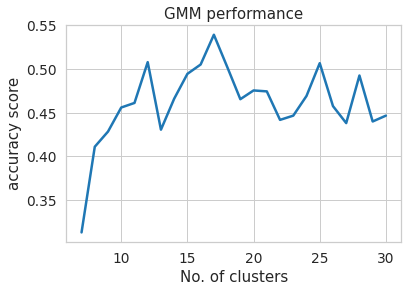

In [ ]:
plt.plot(vals,gmm_accs)
plt.xlabel('No. of clusters')
plt.ylabel('accuracy score')
plt.title('GMM performance')
plt.show()

In [ ]:
best_cluster=vals[gmm_accs.index(max(gmm_accs))]

In [ ]:
test_vectors = []
print("inferring vectors")
duplicate_dict_test = {}
used_lines_test = []
for i, t in enumerate(test['Body']):
  used_lines_test.append(t)
  test_vectors.append(model.infer_vector(preprocess_document(t)))

print("done")

inferring vectors
done


In [ ]:
NUM=12

In [ ]:
gm=GaussianMixture(n_components=NUM)
gm.fit(vectors)
labels=gm.predict(vectors)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(model.docvecs.doctag_syn0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  """Entry point for launching an IPython kernel.


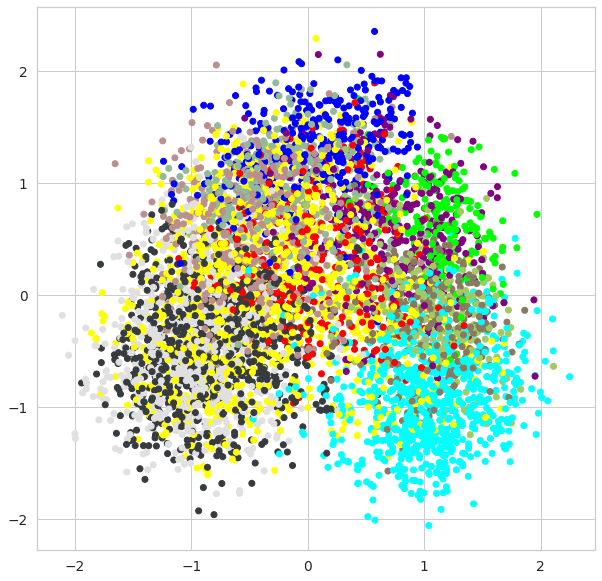

In [ ]:
datapoint = pca.transform(model.docvecs.doctag_syn0)
datapoints=pd.DataFrame(datapoint,columns=['first','second'])
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,10))
label1 = ['#FFFF00', '#FF0000', '#0000FF', '#800080','#00FF00','#00FFFF','#BC8F8F','#897960','#94b998','#e0e0e0','#363b3f','#a3ca61','#ff6f6f','#66FFCC','#808000','#008080','#FFA500','#C0C0C0','#FF1493','#778899']
label1=label1[:NUM]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
#centroids = np.array(loaded_model.means())
#centroidpoint = pca.transform(centroids)
#plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

# Kmeans

In [ ]:
def pred_km(sent,km):
  vect=model.infer_vector(preprocess_document(sent))
  pred=km.classify(vect)
  return(pred)

In [ ]:
from collections import Counter
def km_mode(f):
  ev=list(test[test.km_preds==f]['Category'])
  c=Counter(ev)
  return(c.most_common(1)[0][0])


In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import nltk
from nltk.cluster.kmeans import KMeansClusterer
from tqdm import tqdm
def plot_acc_kmeans(a,b):
  accs=[]
  for k in range(a,b+1):
      print('cluster',k)
      km = KMeansClusterer(k, distance=nltk.cluster.util.cosine_distance, repeats=25)
      assigned_clusters = km.cluster(vectors, assign_clusters=True)


      predskm=[]
      for i in range(len(test)):
        predskm.append(pred_km(test['Body'][i],km))
      #print(set(predsg))
      #if(len(set(predskm))<k):
      # accs.append(0)
      #  continue
      #print('max',max(predsg))
      test['km_preds']=predskm
      cats_km=[]
      for i in set(predskm):
          cats_km.append(km_mode(i))
      
      #print('cats',cats_gmm)
      mapped_km=[]
      for n in predskm:
        #print(n)
        mapped_km.append(cats_km[list(set(predskm)).index(n)])
      #print(list(test['Category'])[:10])
      #print(mapped_gmm)
      print(accuracy_score(list(test['Category']),mapped_km))
      accs.append(accuracy_score(list(test['Category']),mapped_km))
  return(accs)


In [ ]:
km_accs=plot_acc_kmeans(7,20)

cluster 7
0.4930886192597143
cluster 8
0.5192750729534634
cluster 9
0.5807863615420058
cluster 10
0.5694209798802027
cluster 11
0.5933804331131931
cluster 12
0.5791737060359392
cluster 13
0.5900015358623867
cluster 14
0.5839348794348026
cluster 15
0.5787129473199202
cluster 16
0.5806327753033328
cluster 17
0.6058977115650438
cluster 18
0.5769467055751805
cluster 19
0.5783289817232375
cluster 20
0.5725694977729996


In [ ]:
vals=[i for i in range(7,21)]
k=-1
while(True):
  k+=1
  if(k==len(km_accs)):
    break
  if(km_accs[k]==0):
    km_accs.pop(k)
    vals.pop(k)
    k=k-1

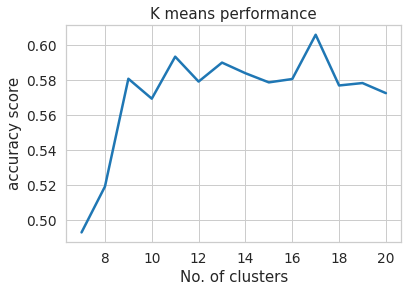

In [ ]:
plt.plot(vals,km_accs)
plt.xlabel('No. of clusters')
plt.ylabel('accuracy score')
plt.title('K means performance')
plt.show()

Hence we achieved maximum accuracy at 17 clusters using Kmeans algorithm . 
Hence this will be our model for classifying new articles 